In [1]:
import numpy as np
from scipy import signal
from numpy import linalg as LA
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import warnings
warnings.filterwarnings('ignore')

# Problem 1

In this problem, we will use PCA, ICA and NMF to perform dimensionality reduction on the spectrogram of audio data consisting of three types of instruments.

In [17]:
# Read data and define hyperparameters
fs, x = wavfile.read('vl1.wav')
x = (x/np.max(x)).astype(float)
window = 'hamming'
nperseg = 2048
noverlap = int(1024 * 1/4)

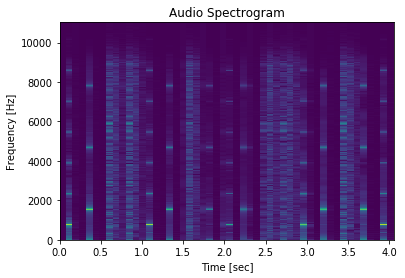

In [18]:
# apply stft and generate spectrogram of the magnitude of the coefficients
f, t, Zxx = signal.stft(x=x, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
X = abs(Zxx) # take absolute value of the coefficients
plt.pcolormesh(t, f, np.sqrt(X))
plt.title('Audio Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [22]:
f

array([0.00000000e+00, 1.07666016e+01, 2.15332031e+01, ...,
       1.10034668e+04, 1.10142334e+04, 1.10250000e+04])

# Algorithms
We now implement our algorithms and encapsulate them all in the model class. 

In [4]:
class Model():
    def __init__(self, X):
        self.X = X; # input data of shape (num_feature, num_sample)
        self.fea_dim = X.shape[0] # feature dimension
        self.sam_dim = X.shape[1] # sample dimension
    
    def PCA(self):
        X_mean = np.mean(self.X, axis=1)
        X_norm = self.X-X_mean[:,None] # normalize X to zero mean
        X_cov = (X_norm @ X_norm.T)/(self.sam_dim-1) # compute covariance matrix using matrix multiplication
        w, v = LA.eigh(X_cov)
        w_inverse_sqrt = np.diag(1/(np.sqrt(w)+1e-6)) # add a small number to ensure numerical stability
        # reverse component order since numpy's eigh function returns eigenvalues in ascending order
        self.Wpca = (w_inverse_sqrt @ v.T)                  
        self.Zpca = (self.Wpca @ X_norm)
        self.Wpca = self.Wpca[::-1]
        self.Zpca = self.Zpca[::-1]
        return self.Zpca, self.Wpca
    
    def ICA(self, red_dim, steps=500, lr=1e-3):
        Zred = self.Zpca[:red_dim].astype(float) # First red_dim PCA weight components
        Wred = np.random.random_sample((red_dim, red_dim)) # First red_dim PCA feature components
        # iteratively update the ICA feature matrix
        for step in range(steps):
            fn = 2 * np.tanh(Wred @ Zred)
            Niden = Zred.shape[1] * np.eye(red_dim)
            Wred += lr * (Niden - fn @ (Wred @ Zred).T) @ Wred
        self.Zica = Wred @ Zred
        self.Wica = LA.pinv(Wred @ self.Wpca[:red_dim, :])
        return self.Zica, self.Wica
    
    def NMF(self, red_dim, steps=500):
        # randomly initialize W an H
        self.Wnmf = np.random.uniform(low=0, high=1, size=(self.fea_dim, red_dim))
        self.Hnmf = np.random.uniform(low=0, high=1, size=(red_dim, self.sam_dim))
        # iteratively update W and H
        for step in range(steps):
            self.Wnmf *= (self.X @ self.Hnmf.T)/(self.Wnmf @ self.Hnmf @ self.Hnmf.T + 1e-6) # add a small number to ensure numerical stability
            self.Hnmf *= (self.Wnmf.T @ self.X)/(self.Wnmf.T @ self.Wnmf @ self.Hnmf + 1e-6)
        return self.Wnmf, self.Hnmf

In [5]:
# run the model and generate components
model1 = Model(X)
Zpca1, Wpca1 = model1.PCA()
Zica1, Wica1 = model1.ICA(red_dim=3)
Wnmf1, Hnmf1 = model1.NMF(red_dim=3)

# Plot
We now have features extracted by each algorithm, so we plot them.

In [6]:
# define a function to plot components
def plot_components(components, title, model_name, component_name, x_axis):
    plt.figure(figsize=(15,12))
    plt.suptitle(title, size=16)
    plt.subplot(311)
    plt.plot(components[0])
    plt.ylabel('1st %s %s component'%(model_name, component_name))
    plt.xlabel(x_axis)
    plt.subplot(312)
    plt.plot(components[1])
    plt.ylabel('2nd %s %s component'%(model_name, component_name))
    plt.xlabel(x_axis)
    plt.subplot(313)
    plt.plot(components[2])
    plt.ylabel('3rd %s %s component'%(model_name, component_name))
    plt.xlabel(x_axis)
    plt.show()

## PCA

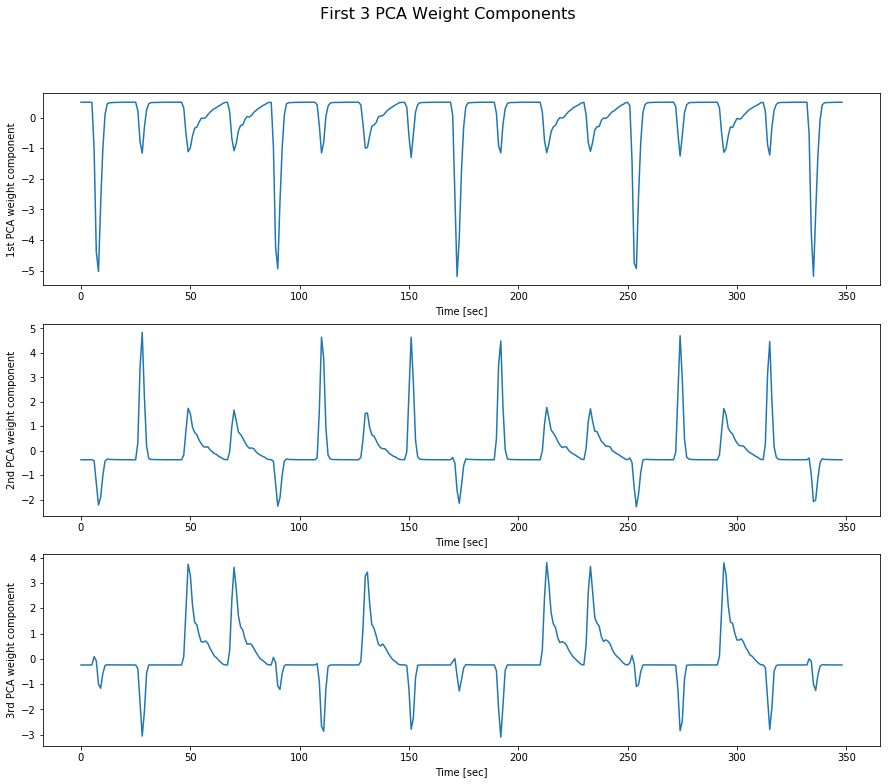

In [7]:
plot_components(Zpca1, 'First 3 PCA Weight Components', 'PCA', 'weight', 'Time [sec]')

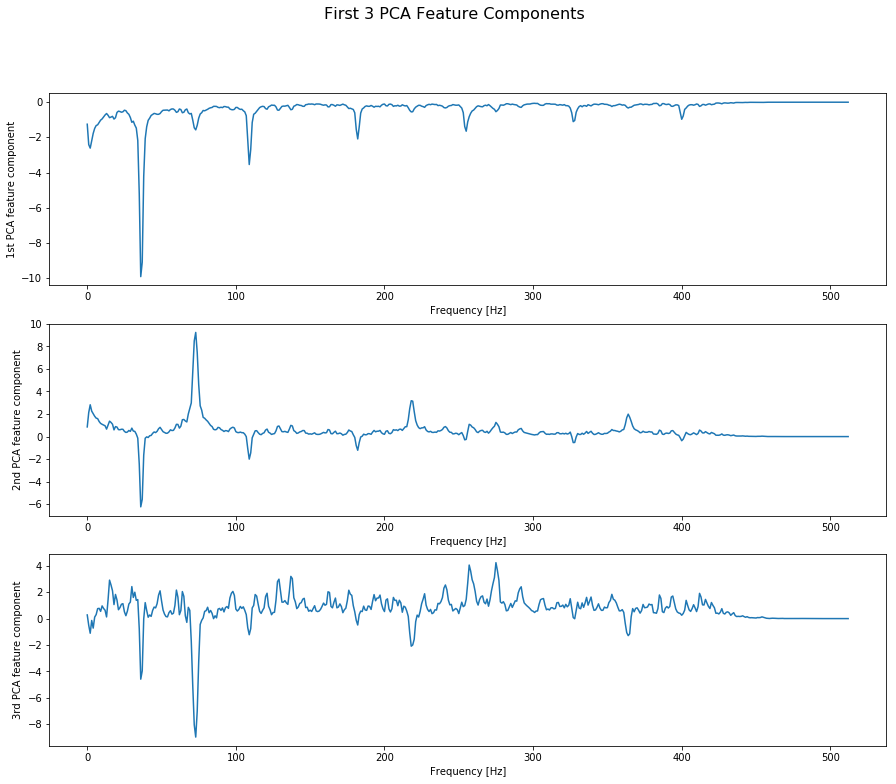

In [8]:
plot_components(Wpca1, 'First 3 PCA Feature Components', 'PCA', 'feature', 'Frequency [Hz]')

As we can see from the above plots, the first three weight components reflect the change of the spectrogram along the time axis. The peaks correspond to the moments when the power of corresponding instrument dominates. The feature components reflect the signal energy at each frequency coefficient. It can be seen that frequency component is associated with the peaks at time: the first component has about 6 peaks along the frequency, the second has about 3, and the third has energy along the whole frequency band. Note that PCA has order so the components are organized in the order they occur in the time domain.

## ICA

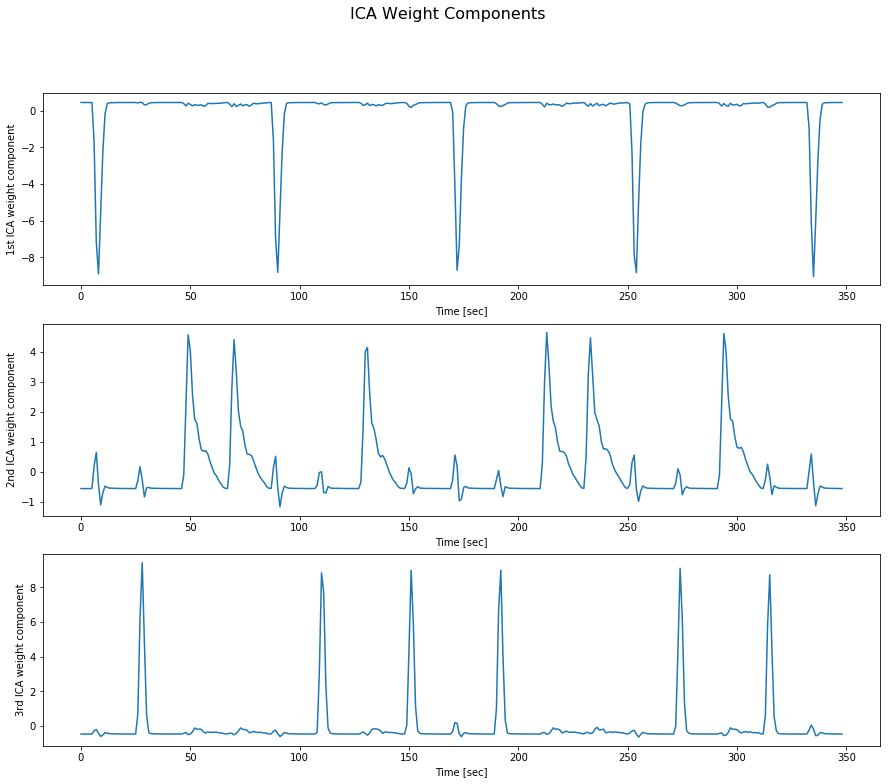

In [9]:
plot_components(Zica1, 'ICA Weight Components', 'ICA', 'weight', 'Time [sec]')

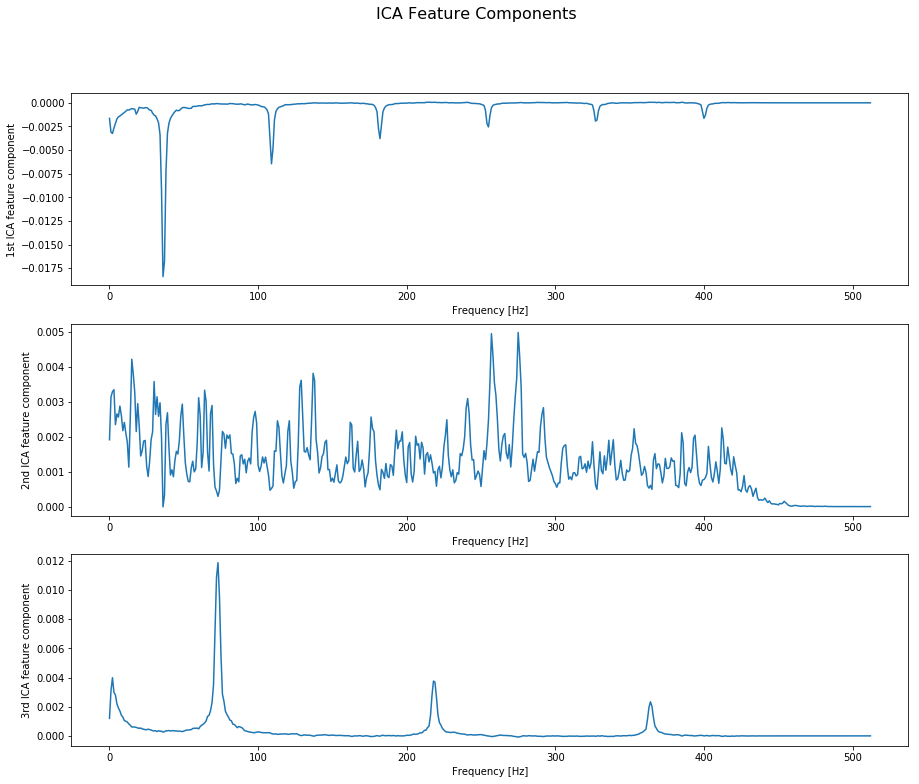

In [10]:
plot_components(Wica1.T, 'ICA Feature Components', 'ICA', 'feature', 'Frequency [Hz]')

The ICA has similar patterns to the PCA. However, since ICA imposes independence, which is stronger than the uncorrelated components generated by PCA, we can see the peaks are more distinguished. Moreover, ICA does not have an order. So even though the components remain the same, the order are undefined and their positions can change if the algorithm is run again.

## NMF

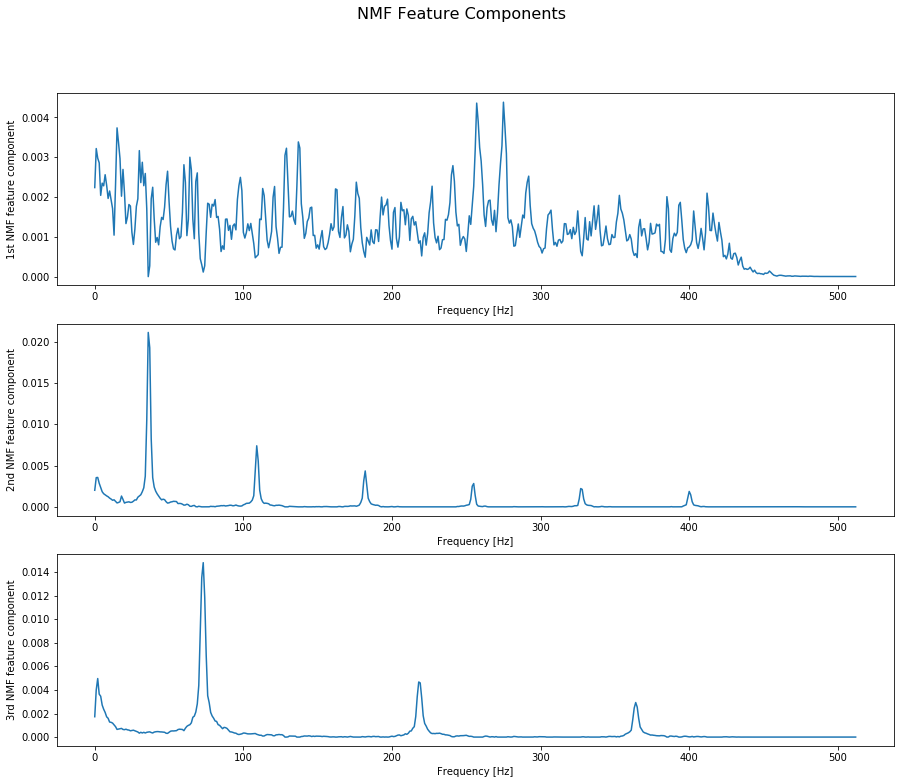

In [11]:
plot_components(Wnmf1.T, 'NMF Feature Components', 'NMF', 'feature', 'Frequency [Hz]')

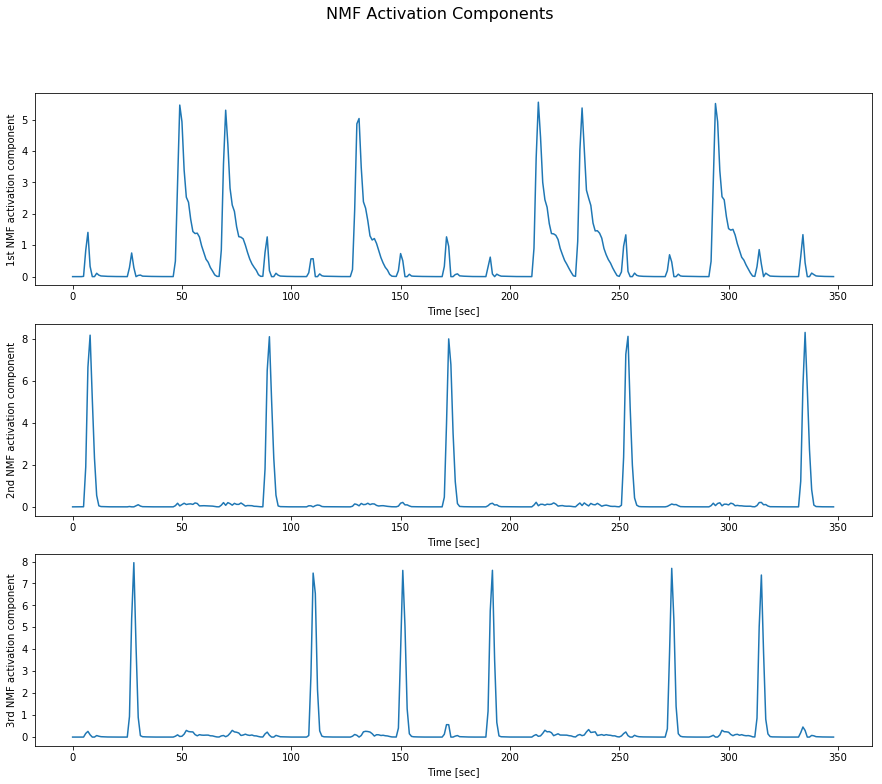

In [12]:
plot_components(Hnmf1, 'NMF Activation Components', 'NMF', 'activation', 'Time [sec]')

From human's perspective, NMF gives the most intuitive data representation. We can easily tell from the feature matrix which component corresponds to which instrument since the peaks are clearly defined. Also, the activation matrix produces sharp impulses at which a particular instrument dominates and remains flat elsewhere. Moreover, the values are all non-negative, which outperforms PCA and ICA in terms of visualization as the other two sometimes give counter-intuitive negative values. Note that just like ICA, NMF also doesn't have order so their positions may be swapped if we run the model again.

# Problem 2

In this problem, we again apply PCA, ICA and NMF on handwritten digits. We then reduce the dimensionality to 36 and see the models can produce.

In [13]:
# read data and label
datafile = np.load('digits-labels.npz')
label = datafile['l']
data = datafile['d']

In [14]:
# run the model
model2 = Model(data)
Zpca2, Wpca2 = model2.PCA()
Zica2, Wica2 = model2.ICA(red_dim=36, lr=1e-6)
Wnmf2, Hnmf2 = model2.NMF(red_dim=36)

# Plot

Just like Problem 1, we plot the images after reducing their dimensionality.

In [15]:
# define image plotting function
def plot_images(images, title):
    plt.figure(figsize=(12,12))
    plt.suptitle(title, size=16)
    for num, image in enumerate(images):
        plt.subplot(6,6,num+1)
        plt.axis('off')
        plt.imshow(np.reshape(image,(28,28),'F'))

# PCA

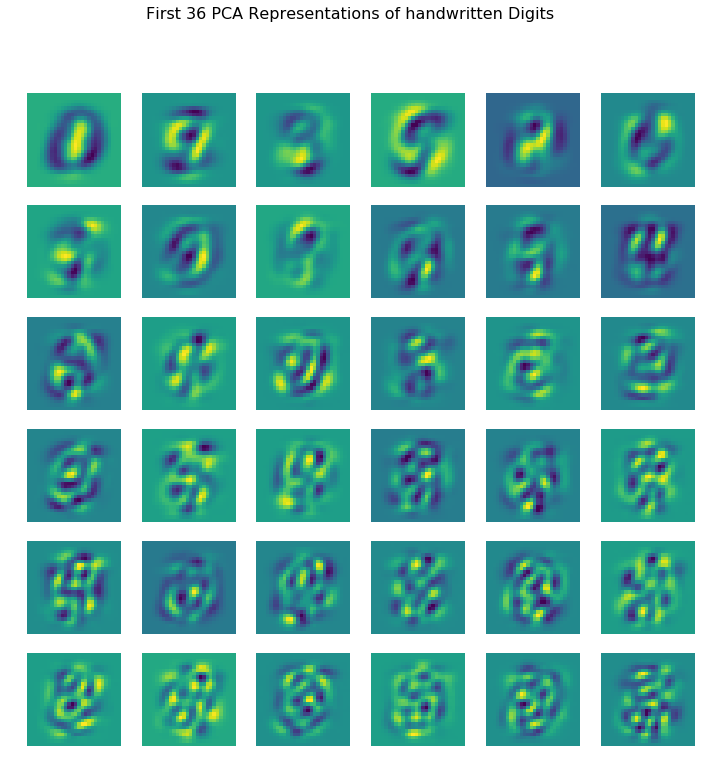

In [16]:
plot_images(Wpca2[:36].astype(float), 'First 36 PCA Representations of handwritten Digits')

When the data becomes images, PCA has a problem in distinguishing the features. For the first images, we may still tell which digit it is. However, as the component weight decreases, it becomes harder and harder to identify the digit.

# ICA

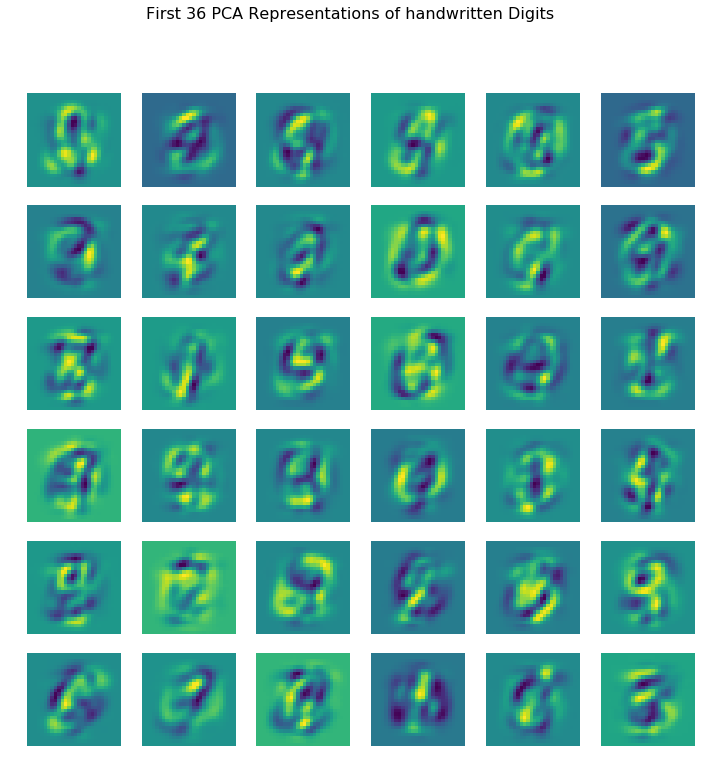

In [17]:
plot_images(Wica2.T[:36].astype(float), 'First 36 PCA Representations of handwritten Digits')

Unlike PCA, ICA imposes feature independence to the data. As a result, we can observe clearer patterns and are able to identity the digits more than a few. In addition, we can see that the digit information such as the strokes are better refined in the center than PCA, displaying the advantages of having independent components.

# NMF

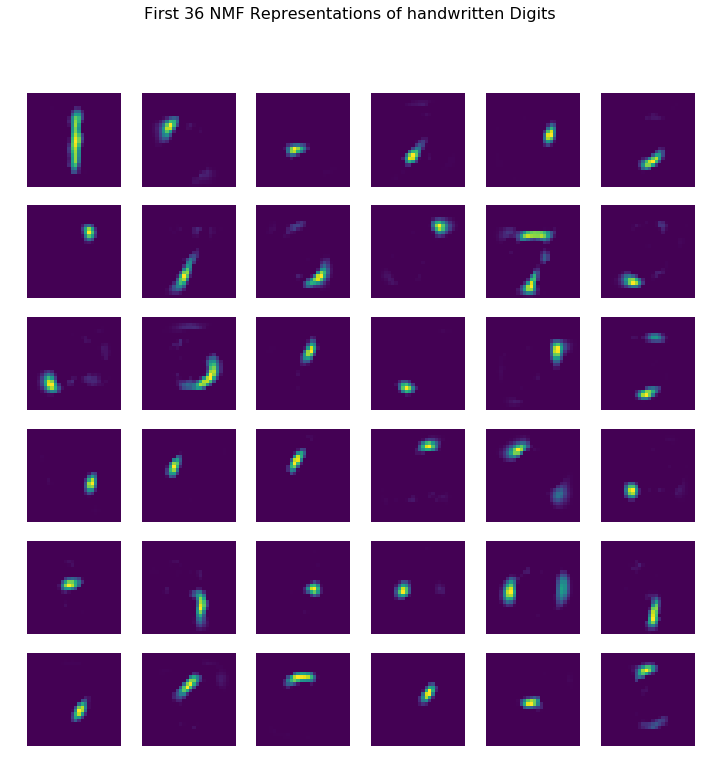

In [18]:
plot_images(Wnmf2.T[:36], 'First 36 NMF Representations of handwritten Digits')

For NMF, we can longer tell which image represents which digit, but the images colors are most normal among the three. Each image now looks like some strokes of a digit, which are the building blocks of the real images. The NMF output can be intepreted as the lower dimension representation of the real data, whichi gives us the most intuitive expression.

# Problem 3

In this problem, we only use digit 6 from the handwritten dataset. We will examine two different dimensionality reduction methods: PCA and ISOMAP.

In [19]:
# Only load data whose label is 6
data6 = data.T[np.where(label==6)[0],:]

In [20]:
# run the model
model3 = Model(data6.T)
Zpca3, Wpca3 = model3.PCA()

# ISOMAP

We also need to implement the ISOMAP algorithm

In [21]:
# define a function to compute the euclidean matrix
def euclidean(data):
    N = data.shape[1]
    diag = np.diagonal(data.T @ data)
    ones = np.ones(N).reshape((N,1))
    return np.sqrt(np.outer(diag, ones) + np.outer(ones.T, diag.T) - 2 * (data.T @ data))

# define whitening function
def norm_fn(Dg):
        N = Dg.shape[0]
        ones = np.ones((N, N))
        S = -1/2 * (Dg - 1/N * Dg @ ones - 1/N * ones @ Dg + 1/(N*N) * ones @ Dg @ ones)
        return S

# the ISOMAP algorithm
def ISOMAP(data, K=6, red_dim=2):
    # compute the euclidean matrix of the data
    D = euclidean(data.T)
    dim = D.shape[0]
    
    # apply KNN
    K_neighbors = D.argsort()
    Dg = np.ones((dim, dim)) * np.inf # initialize the geodesic matrix to be infinite everywhere
    np.fill_diagonal(Dg, 0) # zero the diagonal
    for j in range(len(K_neighbors)):
        Dg[j, K_neighbors[j, 0:K]] = D[j, K_neighbors[j, 0:K]]
    Dg = np.minimum(Dg, Dg.T) # make the matrix symmetric
    
    # apply Floyd's algorithm to compute the geodesic matrix
    for k in range(dim):
        for i in range(dim):
            Dg[i,:] = np.minimum(Dg[i,:], Dg[i,k] + Dg[k,:])
    
    # whiten the geodesic matrix and apply MDS
    S = norm_fn(Dg)
    w, v = LA.eigh(S)
    isomap = np.sqrt(abs(np.diag(w))) @ v.T
    isomap = isomap[::-1]
    return isomap, Dg, S

isomap, Dg, S = ISOMAP(data6, K=7)

# Plot

We now plot the scatter plot of both PCA and ISOMAP and compare/contrast them.

In [22]:
# define scatter plotting function
def scatter_plot(x, y, images, ax, zoom):
    artists = []
    for (x0, y0, image) in zip(x, y, images):
        im = OffsetImage(image.reshape((28,28)).T, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

## PCA

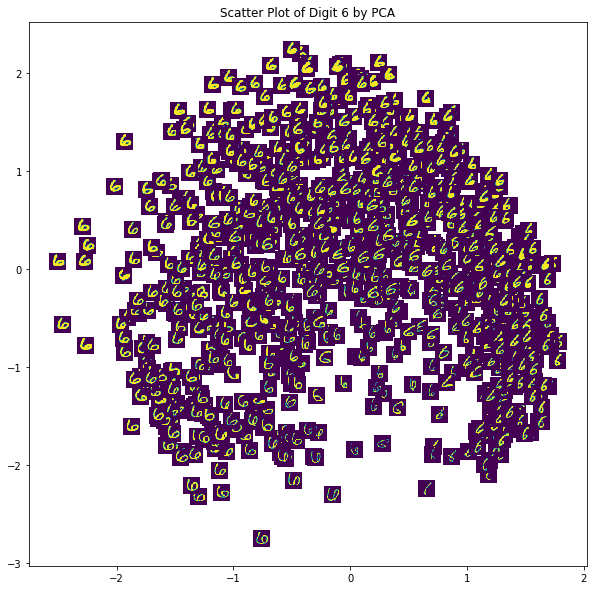

In [23]:
pca_plot = Zpca3
pca_images_plot = data6
fig, ax = plt.subplots(figsize=(10,10))
scatter_plot(pca_plot[0], pca_plot[1], pca_images_plot, ax=ax, zoom=0.6)
ax.scatter(pca_plot[0], pca_plot[1])
plt.title("Scatter Plot of Digit 6 by PCA")
plt.show()

The PCA scatter plot displays a distribution of data which is dense around the center and sparse at the peripheral. However, the distribution has a mean that is shifted off zero and the variance is different at different dimension. 

## ISOMAP

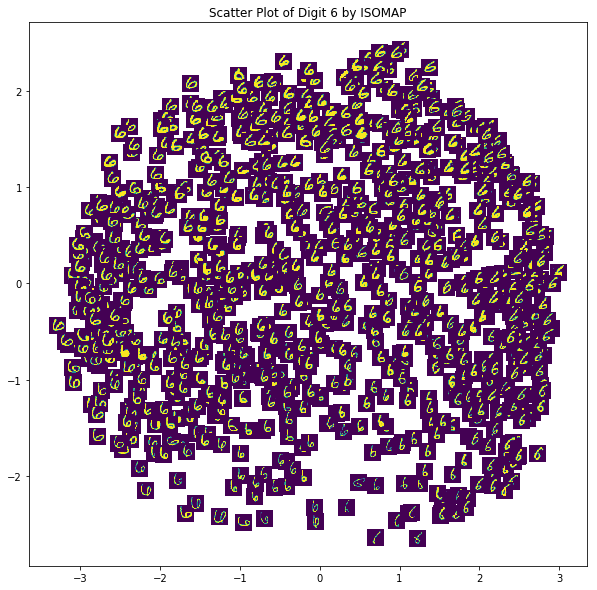

In [24]:
isomap_plot = isomap
isomap_images_plot = data6
fig, ax = plt.subplots(figsize=(10,10))
scatter_plot(isomap_plot[0].astype(float), isomap_plot[1].astype(float), isomap_images_plot, ax=ax, zoom=0.6)
ax.scatter(isomap_plot[0].astype(float), isomap_plot[1].astype(float))
plt.title("Scatter Plot of Digit 6 by ISOMAP")
plt.show()

The ISOMAP plot, as compared to the PCA one, shows more good properties we'd like to have. The distribution is centered around zero, and it looks round, which means the variance is the same along different dimensions. The plot makes sense because ISOMAP, when using euclidean distance as the metric, has very similar properties as PCA. However, because of the whitening step, ISOMAP generates zero mean, more centralized data distribution we favor.